<a href="https://colab.research.google.com/github/afiaka87/clip-guided-diffusion/blob/main/cgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Guided Diffusion 

**From [RiversHaveWings](https://twitter.com/RiversHaveWing)**

Generate vibrant and detailed images using only text.
- Originally by Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings). 
- Python repository and additions assembled by Clay Mullis (https://github.com/afiaka87)
  
- **Some amount of programming knowledge is required to use this notebook.**

**[Read Me](https://github.com/afiaka87/clip-guided-diffusion)**

In [1]:
#@title Licensed under the MIT License

# Copyright (c) 2021 Clay Mullis, Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [2]:
#@title Grab code and install requirements
# colab only
import os
if 'content' in os.getcwd():
    !git clone 'https://github.com/afiaka87/clip-guided-diffusion'
    !git clone 'https://github.com/afiaka87/guided-diffusion'
    %pip install -r /content/clip-guided-diffusion/requirements.txt 
    %pip install -e /content/guided-diffusion
# !wget --continue 'https://www.dropbox.com/s/476l3ytxh3b7kx1/VIT_B_32_noisy_dallegen_epoch1_step5240.pt' -O vitb32_dalleblog_noise.pt
# %pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [3]:
#@title Config
#@markdown Text Prompts
prompts = "armchair in the form of a pikachu" #@param{type: "string"}
image_prompts = "" #@param {type: "string"}

if len(prompts) > 0:
    prompts = prompts.split('|')

if len(image_prompts) > 0:
    image_prompts = image_prompts.split(',')

#@markdown CLIP/Diffusion
image_size = "256"  #@param ["64", "128", "256", "512"]
image_size = int(image_size)
unconditional = False #@param{type: "boolean"}
clip_model_name = "ViT-B/32" #@param ["RN50", "ViT-B/32", "ViT-B/16", "RN50x4", "RN50x16", "vitb32_dalleblog_noise.pt"] {allow-input: true}

#@markdown Initial image (url or path, set to "" to disable)
init_image = "" #@param{type: "string"}
init_scale = 0 #@param {type: "number"}
skip_timesteps =  0#@param{type: "number"}
if len(init_image) > 0 and skip_timesteps == 0:
    print("Overriding skip_timesteps to 500 because init_image is set but skip_timesteps is 0. You may want to override this manually.")
    skip_timesteps = 500
if len(init_image) == 0:
    if skip_timesteps > 0:
        print("Overriding skip_timesteps to 0 because you dont have an init image set.")
        skip_timesteps = 0

#@markdown Knobs
num_cutouts = 32 #@param{type: "number"}
timestep_respacing = "250" #@param ["25", "50", "100", "250", "500", "1000", "ddim25", "ddim50", "ddim100", "ddim250", "ddim500", "ddim1000"]
clip_guidance_scale =  1500 #@param{type: "number"}
tv_scale =  150 #@param{type: "number"}

range_scale =  50 #@param {type: "number"}
cutout_power = 0.5 #@param {type: "number"}
cutout_power = float(cutout_power)
dropout = 0.1 if image_size == 64 else 0.0
num_classes =  0#@param {type: "number"}
#@markdown Output
save_frequency = 5 #@param{type: "number"}

#@markdown "diffusion_steps" schedule of timesteps over which to run diffusion. Values other than 1000 can lead to NaN errors.
diffusion_steps = 1000 #@param {type: "number"}

batch_size = 1 #@param {type: "number"}

random_affine = False #@param{type: "boolean"}
random_motion_blur = False #@param{type: "boolean"}
random_horizontal_flip = False #@param{type: "boolean"}

seed = 0 #@param {type: "number"}

# probably don't touch
noise_schedule = "cosine" if image_size == 64 else "linear"
output_dir = "outputs"
augs = []
import kornia.augmentation as kaugs
if random_affine: augs.append(kaugs.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.1))
if random_motion_blur: augs.append(kaugs.RandomMotionBlur(kernel_size=(3, 5), angle=15, direction=0.5))
if random_horizontal_flip: augs.append(kaugs.RandomHorizontalFlip(p=0.5))
import torch
from torchvision import transforms as T
# augs.append(T.RandomApply([T.Lambda(lambda x : x + torch.randn_like(x)),], p=0.5))
total_steps = int(timestep_respacing.replace("ddim","")) - skip_timesteps

# Load init image.
if len(init_image) > 0:
    if init_image.startswith("http"):
        !wget --continue $init_image -O init_image.jpg
    else:
        !cp -n -v $init_image init_image.jpg
    init_image = "init_image.jpg"
_class_cond = not unconditional

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Run

In [4]:
#@title Imports/Helper functions
import sys
sys.path.append("clip-guided-diffusion")
sys.path.append("guided-diffusion")
import pathlib
from IPython.display import Image as ipy_Image
from IPython.display import display as ipy_display
from IPython.display import clear_output as ipy_clear_output
from tqdm.autonotebook import tqdm
import torch as th
import base64
from PIL import Image as pil_Image
from IPython.display import IFrame
import os
import torch
from cgd.script_util import create_gif

from IPython.display import HTML
import base64

def show_gif(fname):
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return HTML(f'<img src="data:image/gif;base64,{b64}" />')

# thanks @nshepperd!
def refresh_cuda_memory():
    import gc
    gc.collect()
    for obj in gc.get_objects():
        if not isinstance(obj, th.Tensor):
            continue
        if isinstance(obj, th.nn.Parameter):
            obj.grad = None
            continue

        obj.data = obj.data.cpu()
    gc.collect()
    th.cuda.empty_cache()
refresh_cuda_memory()

pathlib.Path("outputs").mkdir(exist_ok=True)
total_steps = int(timestep_respacing.replace("ddim","")) - skip_timesteps
progress_bar = tqdm(total=total_steps, unit="steps")

/opt/conda/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:151: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


True

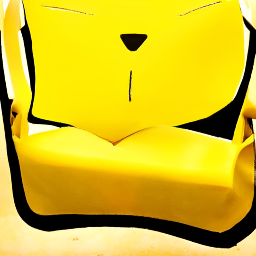

In [5]:
#@title Start diffusion

clear_scrollback = True # @param {type:"boolean"}
display_width = "" 
if len(display_width) > 0:
    display_width = int(display_width)
else:
    display_width = 256 if image_size < 512 else 512

from cgd.cgd import clip_guided_diffusion
cgd_samples = clip_guided_diffusion(
    prompts=prompts,
    image_prompts=image_prompts,
    batch_size=batch_size,
    tv_scale=tv_scale,
    range_scale=range_scale,
    image_size=image_size,
    class_cond=_class_cond,
    clip_guidance_scale=clip_guidance_scale,
    cutout_power=cutout_power,
    num_cutouts=num_cutouts,
    timestep_respacing=timestep_respacing,
    seed=seed,
    diffusion_steps=diffusion_steps,
    skip_timesteps=skip_timesteps,
    init_image=init_image,
    init_scale=init_scale,
    clip_model_name=clip_model_name,
    randomize_class=(_class_cond),
    noise_schedule=noise_schedule,
    dropout=dropout
)
for batch_idx, img in cgd_samples:
    if clear_scrollback and batch_idx == 0:
        ipy_clear_output(wait=True)
    progress_bar.set_description(f"Saved image {img}")
    progress_bar.update()
    ipy_display(ipy_Image(img, width=display_width))

gif_paths = [ create_gif(base='outputs',prompts=prompts,batch_idx=batch_idx) for batch_idx in range(batch_size) ]


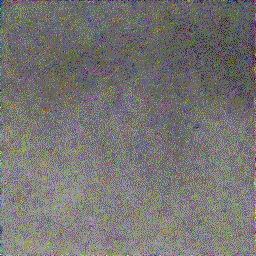

In [6]:
#@title Display gifs
def gif_html_img_str(gif_path):
    with open(gif_path, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return f'<img src="data:image/gif;base64,{b64}" />'


for gif_path in gif_paths:
    ipy_display(HTML(gif_html_img_str(gif_path)))